In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import gsw
import matplotlib as mpl
import cmocean.cm as cm

In [3]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
tmask = mesh.tmask[0]

In [4]:
tmask_use = tmask.isel(z=0).rename({'x':'gridX','y':'gridY'})

In [5]:
# example_day = xr.open_dataset('/results2/SalishSea/nowcast-green.201905/29sep22/SalishSea_1h_20220929_20220929_grid_T.nc')
# depth_ex = example_day.deptht

In [6]:
example_river = xr.open_dataset('/results/forcing/rivers/R202108Dailies_y2014m06d23.nc')

In [7]:
ww_fresh = xr.open_dataset('/ocean/cdonaldson/scrubbers/daily_obs/scrubber_obs_freshcalc_ALL2019.nc')
ww_fresh = ww_fresh.rename({'x':'gridX','y':'gridY'})
ww_fresh = ww_fresh.rename_vars({'washwater': 'washwater_mass'})
ww_fresh

<xarray.Dataset>
Dimensions:         (time: 365, gridY: 898, gridX: 398)
Coordinates:
  * time            (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-12-31
  * gridY           (gridY) int64 0 1 2 3 4 5 6 ... 891 892 893 894 895 896 897
  * gridX           (gridX) int64 0 1 2 3 4 5 6 ... 391 392 393 394 395 396 397
Data variables:
    washwater_mass  (time, gridY, gridX) float32 ...

In [8]:
phys = xr.open_dataset('/ocean/cdonaldson/scrubbers/day_avg_extractions/SalishSeaCast_day_avg_phys_tracers__20190101_20191231.nc')
phys

<xarray.Dataset>
Dimensions:   (time: 365, depth: 1, gridY: 898, gridX: 398)
Coordinates:
  * time      (time) datetime64[ns] 2019-01-01T12:00:00 ... 2019-12-31T12:00:00
  * depth     (depth) float32 0.5
  * gridY     (gridY) int64 0 1 2 3 4 5 6 7 ... 890 891 892 893 894 895 896 897
  * gridX     (gridX) int64 0 1 2 3 4 5 6 7 ... 390 391 392 393 394 395 396 397
Data variables:
    votemper  (time, depth, gridY, gridX) float32 ...
    vosaline  (time, depth, gridY, gridX) float32 ...
Attributes:
    name:         SalishSeaCast_day_avg_phys_tracers__20190101_20191231
    description:  Day-averaged river dye extracted from SalishSeaCast v202111...
    history:      2026-01-28 13:50 -08:00: Generated by `reshapr extract /oce...
    Conventions:  CF-1.6

# Goal
Transform ww_fresh into ww_est by adding salt and temperature, and replacing the stand-in depth with a static estimated depth for the model.

### Salt
Assume that the water at the outflow is the same salinity as the water at the intake, and that there is little delay in processing time within the scrubber system. Since we are doing daily runs, we can use the day-averaged salinity over the domain instead of hourly salinity. This means that these results will most likely represent open-loop scrubber systens.

***Day-avg sal at (X, Y) grid point***

### Temperature
A little bit trickier, since there isn't much literature about the temperature at the outflow and the guidelines (60C?) seem to be much more generous than any real values. Discussions of temperature tended to be buried within discussions of pH. There are two case studies summarized in the EPA report from 2011, "Exhaust Gas Scrubber Washwater Effluent" (inst. both references) and a modelling study from Ristea et al., "Computational Fluid Dynamics Simulation Approach for Scrubber Wash Water pH Modelling." Based on these, I am going to make the temperature at the outfall a function of the temperature of the intake water, with just an addition of X degrees.

Riseta et al.: CFD study, they set seawater temp at 25°C and discharge water temp to 35°C.
Flagiello et al.: experimental study of alkaline additives to washwater, not in-situ. Water at the intake was 20°C, and exited in the range of 30°C to 50°C.
EPA Study: cites two experimental studies, text found availible for one of them. THE MS ZAANDAMSEAWATER, Holland America Cruise Liner: increase in washwater temperature was less than 3.5°C (HA & H-K, 2010). Text not found for me to read and validate their numbers. THE PRIDE OF KENT, Ferry between Dover and Calais: MArch +1.9°C, July 4.1°C, September 11.9°C, November 16.9°C (Hufnagl et al., 2005). Avg = 8.7°C.

Take the average of both studies = 6.1°C. I'm not very confident in this, so I'm going to go with order of magnitude and say +10°C for all seasons at all locations.

***Day-avg temp at (X, Y) grid point + 10°C***

### Depth
This one is also tricky, since we already know that we will not be able to exactly represent the depth. Ships will sit higher or lower in the water based on their cargo load, and we don't have that information for our data. One solution could be to pick one average depth, but I think it may be better to pick a range of depth to distribute the effluent outfall over since we have fine, 1m resolution in the model. Now, the question becomes one of "what range" and I hope would be a better representation for us to do time-averaged studies on. Does this then impact the assumption I am about to make where I use the surface salinity and temperature as my starting intake values?

The main types of ship to focus on are merchant bulk, merchant container, and cruise ships based on the ECCC emissions simulation tool.

#### Draft Values
Merchant Bulk: 10 - 20 meters (https://shippingandcommodityacademy.com/blog/list-of-bulk-vessel-sizes-an-overview-of-maritime-freight-options/, https://ouco-industry.com/bulk-carriers-explained-types-uses-why-they-matter/#:~:text=Table_title:%20Class%20of%20Bulk%20Carrier%20Table_content:%20header:,120%2C000%E2%80%93200%2C000%20DWT%20%7C%20Draft:%20~16%20m%20%7C)

Merchant Container: 8 - 16 meters (https://transportgeography.org/contents/chapter5/maritime-transportation/draft-containership-capacity/)

Cruise: 4 - 8m (https://www.cruisemapper.com/wiki/753-cruise-ship-sizes-comparison-dimensions-length-weight-draft, put lower range at half of max draft to align with the bulk and container references, looked up examples of common cruise ships that have transited the Salish Sea: Holland America: 8m, 8m | Princess: 8.55m, 8m, | Royal Caribbean: 8.8m, 8.82m, | Celebrity: 8.62m, 8.30m | Norwegian: 3m, 8.72m)

We should also consider that the ship parameters are likely limited by the ports they are able to stop through. Since our dataset does not include Puget Sound, we will assume that the shipping traffic in the SoG that we see is bound for the Port of Vancouver, as opposed to the Port of Seattle or the Port of Tacoma. The maximum draft listed for the port of Vancouver is ~ 15 meters (https://www.findaport.com/port-of-vancouver-canada#limits). Port of Seattle is 15 m (https://en.wikipedia.org/wiki/United_States_container_ports) and Port of Tacoma is 15 m (https://en.wikipedia.org/wiki/United_States_container_ports). I will also assume that before the port, the ships are not ballasted lower.

This gives new ranges of 10 - 15m (merchant bulk), 8 - 15m (merchant container), and 4 - 8m (cruise).

#### Scrubber Outlet Depth
For these types of ships, we assume that the scrubber outlet depth will always be below sea level, but is not often on the bottom of the hull (interference with prop system). Let's also assume that sailing in the fully unloaded state (i.e. unloaded repositioning) is unlikely, as operation is costly within global shipping. 

<!-- I will incorporate this mathematically by assuming that ships will always be at least 130% of their minimum draft. We can determine upper and lower estimates for the hull position of the scrubber outlets as  -->

<!-- $$u = 1.3 \times x_{min} + a$$
$$l = x_{max} - a$$ -->

<!-- $$u = 0.5 \times x_{max} + a - (0.25 \times x_{max})$$
$$l = x_{max} - a - (0.25 \times x_{max})$$ -->
<!-- 
where $a$, allowance, is the distance the scrubber sits from the keel and the minimum waterline, x_{min} is the minimum draft, and $x_{max}$ is the maximum draft. 

We should cap the "maximum draft" to 15 to arrive at the following ranges: 15 - 13m (bulk, 2m allowance), 12.4 - 13m (container, 2m allowance), and 6.2 - 7m (cruise, 1m allowance).  -->

Mathematical estimates commented out, showing deep estimates of 12 - 13m (bulk, 2m allowance), 8 - 13m (container, 2m allowance), and 5 - 7m (cruise, 1m allowance).

<!-- 12 - 13m (bulk, 2m allowance), 8 - 13m (container, 2m allowance), and 5 - 7m (cruise, 1m allowance).  -->

<!-- Our in-situ scrubber depth ranges then become 2 - 13m, 2 - 13m, and 1 - 7m to capture the fully unloaded state (scrubber depth at allowance) as well as the loaded to Salish Sea port capacity state (scrubber depth at max draft - allowance).  This gives new ranges -->

<!-- and we have assumed that the vessel rides on average in the middle of its draft range.  -->
<!-- This gives us 7 - 13 (2m safety), 6 - 10 (2m safety), and 3 - 5 (1m safety) which we can then simplify to a total depth range of 3m - 13m to use in the model. If we want to pick a single value from this, we land on 8m depth. -->

Alternatively, we can take 2.8m from Val et al., the maximum draft of 15 in the ports, and an allowance estimate based on the diagram in the patent to estimate the 3 - 13m for the large ships coming through the Salish Sea. Can either use this range, or we can say 8m depth which is closest to either 7.5m or 8.5m. I am inclined to go with 8.5m, since most of the traffic we are estimating comes from the sum of bulk and container shipping.

<!-- The range is practically all in the average estuarine layer, but since we are doing day averaged things near the FRP, I am inclined to not want to condense it to one. Plus, shouldn't it have mixed as the ship moves through? I'm struggling with this one. Make the files for both? -->

***3m - 13m range*** OR ***8.5m***

In [9]:
example_river

<xarray.Dataset>
Dimensions:       (x: 398, y: 898, time_counter: 1)
Coordinates:
  * x             (x) int64 0 1 2 3 4 5 6 7 ... 390 391 392 393 394 395 396 397
  * y             (y) int64 0 1 2 3 4 5 6 7 ... 890 891 892 893 894 895 896 897
  * time_counter  (time_counter) int64 0
Data variables:
    rorunoff      (time_counter, y, x) float64 ...
Attributes:
    acknowledgements:      Based on river fit
    creator_email:         sallen@eoas.ubc.ca
    creator_name:          Salish Sea MEOPAR Project Contributors
    creator_url:           https://salishsea-meopar-docs.readthedocs.org/
    institution:           UBC EOAS
    institution_fullname:  Earth, Ocean & Atmospheric Sciences, University of...
    title:                 Rivers for y2014m06d23
    notebook:              MakeDailyRiverNCfiles.ipynb
    rivers_base:           river_202108
    summary:               Daily Runoff for Bathymetry 202108
    history:               [2022-11-09] File creation.

In [10]:
phys["time"] = phys.time.dt.floor("D")  ## standardize the times so I can merge the datasets
ww_fresh["time"] = ww_fresh.time.dt.floor("D")

# Salt and Temperature

In [11]:
phys_squeezed = phys.squeeze('depth')  ## remove depth as a coordinate to consider in the merge
phys_squeezed

<xarray.Dataset>
Dimensions:   (time: 365, gridY: 898, gridX: 398)
Coordinates:
  * time      (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-12-31
    depth     float32 0.5
  * gridY     (gridY) int64 0 1 2 3 4 5 6 7 ... 890 891 892 893 894 895 896 897
  * gridX     (gridX) int64 0 1 2 3 4 5 6 7 ... 390 391 392 393 394 395 396 397
Data variables:
    votemper  (time, gridY, gridX) float32 ...
    vosaline  (time, gridY, gridX) float32 ...
Attributes:
    name:         SalishSeaCast_day_avg_phys_tracers__20190101_20191231
    description:  Day-averaged river dye extracted from SalishSeaCast v202111...
    history:      2026-01-28 13:50 -08:00: Generated by `reshapr extract /oce...
    Conventions:  CF-1.6

In [12]:
phys_sq_hot = phys_squeezed  ## make a copy of phys squeezed
hot_temp = phys_sq_hot['votemper'] + 10  ## the outlet temp is the inlet temp plus 10
hot_temp.attrs["units"] = "C" 
hot_temp.attrs["standard_name"] = "outlet temperature"
hot_temp.attrs.pop("long_name", None)
phys_sq_hot['votemper'] = hot_temp  ## put this outlet temp back into the dataset, override previous temp

In [13]:
# ww_fresh1, phys_sq_hot = xr.align(ww_fresh, phys_sq_hot, join='exact')

In [14]:
ww_fresh_hot = xr.merge([phys_sq_hot, ww_fresh])
ww_fresh_hot = ww_fresh_hot.rename_vars({'votemper': 'temp_out', 'vosaline': 'sal_out'})  ## rename the variables

(array([3.5922452e+07, 9.5094000e+04, 2.2843690e+06, 9.4003200e+06,
        8.4813140e+06, 4.0139860e+06, 2.7652380e+06, 2.6906920e+06,
        9.1416500e+05, 2.3700000e+04]),
 array([-2.42449355,  0.44448474,  3.31346297,  6.18244123,  9.05141926,
        11.92039776, 14.78937626, 17.65835381, 20.52733231, 23.39631081,
        26.26528931]),
 <BarContainer object of 10 artists>)

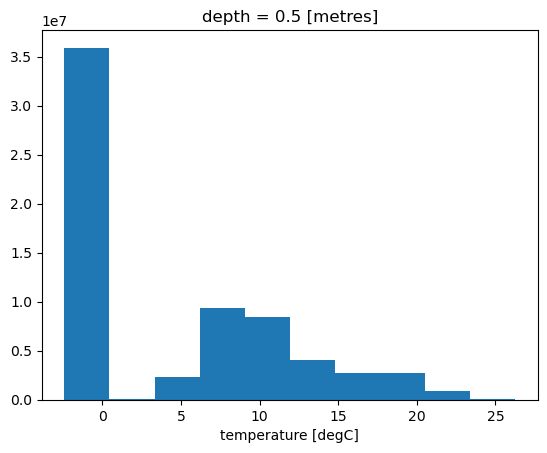

In [15]:
phys['votemper'].plot()

(array([3.5922452e+07, 9.5094000e+04, 2.2843690e+06, 9.4003220e+06,
        8.4813120e+06, 4.0139830e+06, 2.7652410e+06, 2.6906920e+06,
        9.1416500e+05, 2.3700000e+04]),
 array([ 7.57550621, 10.44448471, 13.31346321, 16.18244171, 19.05142021,
        21.92039871, 24.78937531, 27.65835381, 30.52733231, 33.39631271,
        36.26528931]),
 <BarContainer object of 10 artists>)

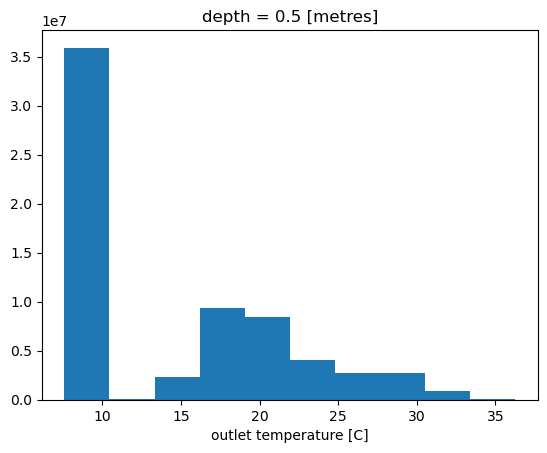

In [16]:
ww_fresh_hot['temp_out'].plot()

In [17]:
mask = ww_fresh_hot["washwater_mass"].notnull()
mask

<xarray.DataArray 'washwater_mass' (time: 365, gridY: 898, gridX: 398)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-12-31
    depth    float32 0.5
  * gridY    (gridY) int64 0 1 2 3 4 5 6 7 8 ... 890 891 892 893 894 895 896 897
  * gridX    (gridX) int64 0 1 2 3 4 5 6 7 8 ... 390 391 392 393 394 395 396 397

In [18]:
ww_fresh_hot["temp_out"] = ww_fresh_hot["temp_out"].where(mask)  ## set temp and sal to nan where no washwater vals
ww_fresh_hot["sal_out"] = ww_fresh_hot["sal_out"].where(mask)

In [19]:
ww_fresh_hot["temp_out"] = ww_fresh_hot["temp_out"].where(tmask_use)  ## set temp, sal, washwater to nan where model land
ww_fresh_hot["sal_out"] = ww_fresh_hot["sal_out"].where(tmask_use)
ww_fresh_hot["washwater_mass"] = ww_fresh_hot["washwater_mass"].where(tmask_use)

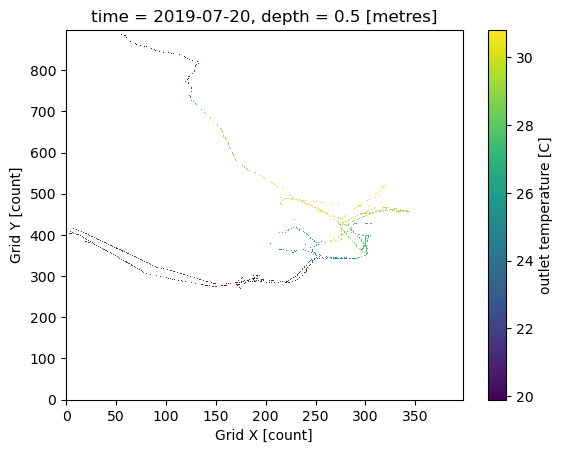

In [20]:
ww_fresh_hot.isel(time=200)['temp_out'].plot()

In [21]:
pressure_dbar = 8.5
ww_swv = ww_fresh_hot
ww_swv['pressure'] = pressure_dbar

In [22]:
rho = gsw.density.rho(ww_swv['sal_out'], ww_swv['temp_out'], ww_swv['pressure'])
rho.attrs["units"] = "kg m-3" 
rho.attrs["standard_name"] = "density"
rho.attrs.pop("long_name", None)

ww_swv['rho'] = rho/1000

In [23]:
ww_swv['washwater'] = ww_swv['washwater_mass'] * (1/ww_swv['rho'])

# Depth

In [24]:
# float(depth_ex[8].values)

In [25]:
# ww_swv = ww_swv.expand_dims(depth=[float(depth_ex[8].values)])

In [26]:
ww_swv = ww_swv.drop_vars(['pressure', 'rho', 'washwater_mass', 'depth'])

# Final Cleaning

I did not get a clear answer on if the things that looked like outliers were actually outliers. I have removed them for this reason.

In [27]:
washwater_flat = ww_swv.washwater.values.flatten()
temp_out_flat = ww_swv.temp_out.values.flatten()
sal_out_flat = ww_swv.sal_out.values.flatten()

washwater_flat = washwater_flat[~np.isnan(washwater_flat)]
temp_out_flat = temp_out_flat[~np.isnan(temp_out_flat)]
sal_out_flat = sal_out_flat[~np.isnan(sal_out_flat)]

Text(66.22222222222221, 0.5, 'g kg$^{-1}$')

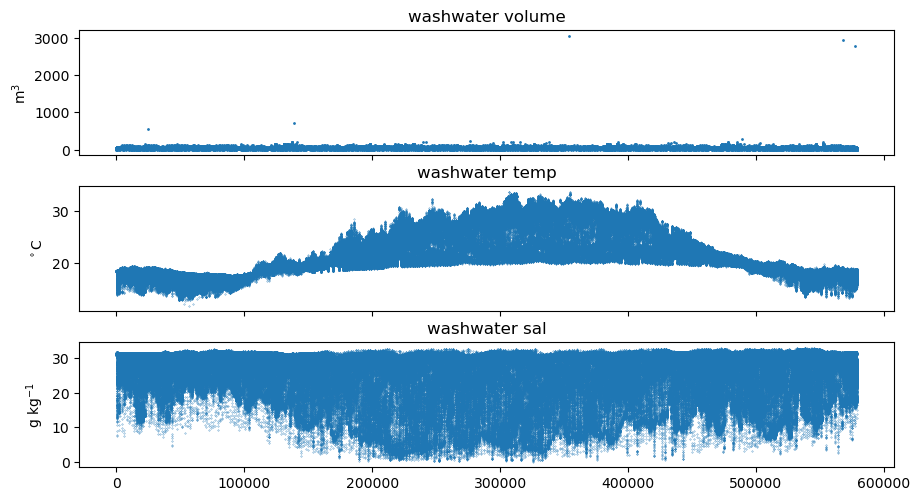

In [28]:
fig, ax = plt.subplots(3, 1, figsize=(9, 5), sharex=True)
fig.tight_layout(pad=1.2)
ax[0].plot(np.arange(len(washwater_flat)), washwater_flat, '.', markersize=2)
ax[0].set_title('washwater volume')
ax[0].set_ylabel(r'm$^3$')

ax[1].plot(np.arange(len(temp_out_flat)), temp_out_flat, '.', markersize=0.5)
ax[1].set_title('washwater temp')
ax[1].set_ylabel(r'$^\circ$C')

ax[2].plot(np.arange(len(sal_out_flat)), sal_out_flat, '.', markersize=0.5)
ax[2].set_title('washwater sal')
ax[2].set_ylabel(r'g kg$^{-1}$')

In [29]:
vol_mask = ww_swv["washwater"] < 500  ## filter out those five outliers in the volume
vol_mask.sum()

<xarray.DataArray 'washwater' ()>
array(579114)

In [30]:
ww_swv["temp_out"] = ww_swv["temp_out"].where(vol_mask)  ## set temp, sal, washwater to nan where model land
ww_swv["sal_out"] = ww_swv["sal_out"].where(vol_mask)
ww_swv["washwater"] = ww_swv["washwater"].where(vol_mask)

In [31]:
washwater_flat = ww_swv.washwater.values.flatten()
temp_out_flat = ww_swv.temp_out.values.flatten()
sal_out_flat = ww_swv.sal_out.values.flatten()

washwater_flat = washwater_flat[~np.isnan(washwater_flat)]
temp_out_flat = temp_out_flat[~np.isnan(temp_out_flat)]
sal_out_flat = sal_out_flat[~np.isnan(sal_out_flat)]

Text(66.22222222222221, 0.5, 'g kg$^{-1}$')

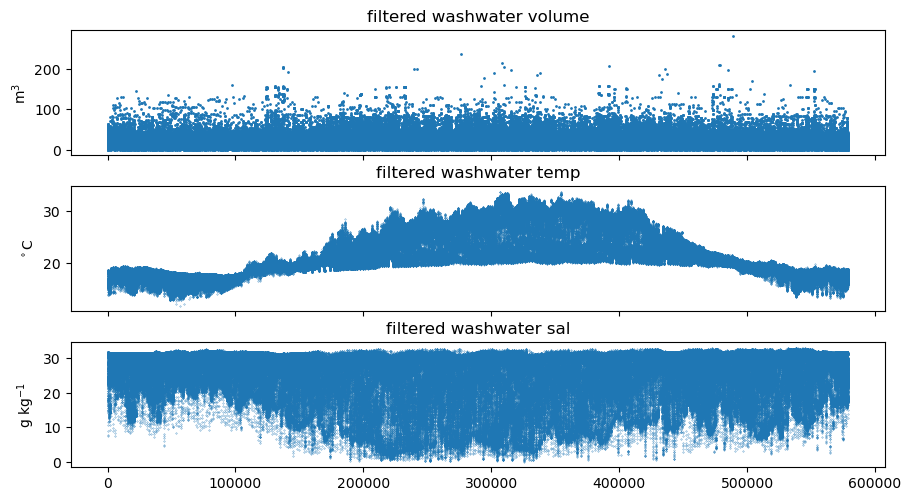

In [32]:
fig, ax = plt.subplots(3, 1, figsize=(9, 5), sharex=True)
fig.tight_layout(pad=1.2)
ax[0].plot(np.arange(len(washwater_flat)), washwater_flat, '.', markersize=2)
ax[0].set_title('filtered washwater volume')
ax[0].set_ylabel(r'm$^3$')

ax[1].plot(np.arange(len(temp_out_flat)), temp_out_flat, '.', markersize=0.5)
ax[1].set_title('filtered washwater temp')
ax[1].set_ylabel(r'$^\circ$C')

ax[2].plot(np.arange(len(sal_out_flat)), sal_out_flat, '.', markersize=0.5)
ax[2].set_title('filtered washwater sal')
ax[2].set_ylabel(r'g kg$^{-1}$')

# Final Look, Saving as Dailies

In [33]:
## Kernel crash
# ww_swv.washwater[:, :] = np.nan_to_num(ww_swv.washwater[:, :])

In [34]:
# ww_swv.to_netcdf('/ocean/cdonaldson/scrubbers/yearly_obs/scrubber_1d_obs_tempsalcalc_nantonum_20190101_20191231.nc')  ## the final dataset

In [45]:
for i in np.arange(len(ww_swv.time)):
    day_dat = ww_swv.isel(time=i)
    day_dat.washwater[:, :] = np.nan_to_num(day_dat.washwater[:, :])
    day_str = str(day_dat.time.values.astype('datetime64[D]')).replace('-', '')
    year = day_str[0:4]
    month = day_str[4:6]
    day = day_str[6:8]

    save_loc = '/ocean/cdonaldson/scrubbers/daily_obs/tempsalcalc_nantonum/'
    day_dat.to_netcdf('{}scrubber_obs_tempsalcalc_y{}m{}d{}.nc'.format(save_loc, year, month, day), unlimited_dims=('time'))

In [ ]:
day_dat.washwater[:, :] = np.nan_to_num(day_dat.washwater[:, :])
# day_dat.washwater[:, :] = np.nan_to_num(day_dat.washwater[:, :])
# day_dat.washwater[:, :] = np.nan_to_num(day_dat.washwater[:, :])

In [47]:
test_day = xr.open_dataset('/ocean/cdonaldson/scrubbers/daily_obs/tempsalcalc_nantonum/scrubber_obs_tempsalcalc_y2019m06d15.nc')
test_day

<xarray.Dataset>
Dimensions:    (gridY: 898, gridX: 398)
Coordinates:
    time       datetime64[ns] ...
  * gridY      (gridY) int64 0 1 2 3 4 5 6 7 ... 890 891 892 893 894 895 896 897
  * gridX      (gridX) int64 0 1 2 3 4 5 6 7 ... 390 391 392 393 394 395 396 397
Data variables:
    temp_out   (gridY, gridX) float32 ...
    sal_out    (gridY, gridX) float32 ...
    washwater  (gridY, gridX) float64 ...
Attributes:
    name:         SalishSeaCast_day_avg_phys_tracers__20190101_20191231
    description:  Day-averaged river dye extracted from SalishSeaCast v202111...
    history:      2026-01-28 13:50 -08:00: Generated by `reshapr extract /oce...
    Conventions:  CF-1.6

In [48]:
test_day.washwater

<xarray.DataArray 'washwater' (gridY: 898, gridX: 398)>
[357404 values with dtype=float64]
Coordinates:
    time     datetime64[ns] ...
  * gridY    (gridY) int64 0 1 2 3 4 5 6 7 8 ... 890 891 892 893 894 895 896 897
  * gridX    (gridX) int64 0 1 2 3 4 5 6 7 8 ... 390 391 392 393 394 395 396 397

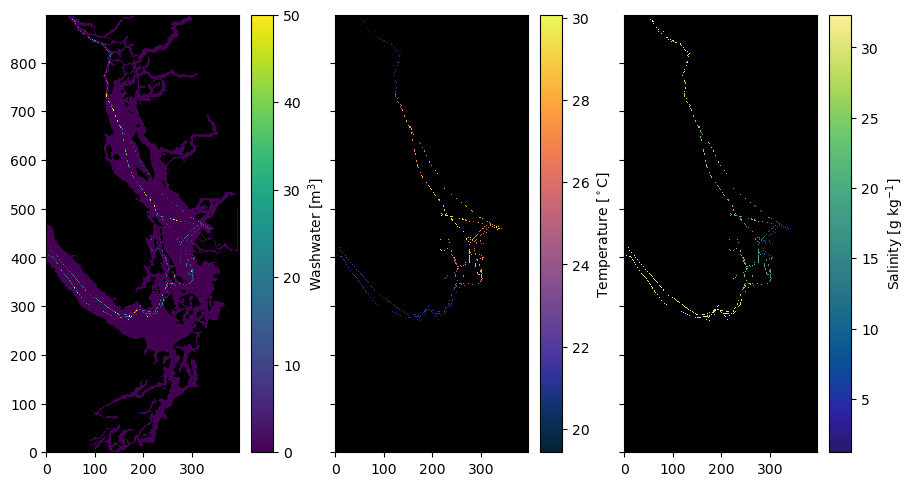

In [49]:
cmap0 = mpl.colormaps['viridis']
cmap0.set_bad('black')

cmap1 = cm.thermal
cmap1.set_bad('black')

cmap2 = cm.haline
cmap2.set_bad('black')

fig, ax = plt.subplots(1, 3, figsize=(9, 5), sharex=True, sharey=True)
fig.tight_layout(pad=1.2)
washwater = ax[0].pcolormesh(np.ma.masked_array(test_day.washwater, mask=(1-tmask[0])), vmax=50, cmap=cmap0)
temp_out = ax[1].pcolormesh(np.ma.masked_array(test_day.temp_out, mask=(1-tmask[0])), cmap=cmap1)
sal_out = ax[2].pcolormesh(np.ma.masked_array(test_day.sal_out, mask=(1-tmask[0])), cmap=cmap2)

cb0 = fig.colorbar(washwater, ax=ax[0])
cb0.set_label(r'Washwater [m$^3$]')
cb1 = fig.colorbar(temp_out, ax=ax[1])
cb1.set_label(r'Temperature [$^\circ$C]')
cb2 = fig.colorbar(sal_out, ax=ax[2])
cb2.set_label(r'Salinity [g kg$^{-1}$]')

In [40]:
test_year = xr.open_dataset('/ocean/cdonaldson/scrubbers/yearly_obs/scrubber_1d_obs_tempsalcalc_20190101_20191231.nc')
test_year

<xarray.Dataset>
Dimensions:    (time: 365, gridY: 898, gridX: 398)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-12-31
  * gridY      (gridY) int64 0 1 2 3 4 5 6 7 ... 890 891 892 893 894 895 896 897
  * gridX      (gridX) int64 0 1 2 3 4 5 6 7 ... 390 391 392 393 394 395 396 397
Data variables:
    temp_out   (time, gridY, gridX) float32 ...
    sal_out    (time, gridY, gridX) float32 ...
    washwater  (time, gridY, gridX) float64 ...
Attributes:
    name:         SalishSeaCast_day_avg_phys_tracers__20190101_20191231
    description:  Day-averaged river dye extracted from SalishSeaCast v202111...
    history:      2026-01-28 13:50 -08:00: Generated by `reshapr extract /oce...
    Conventions:  CF-1.6

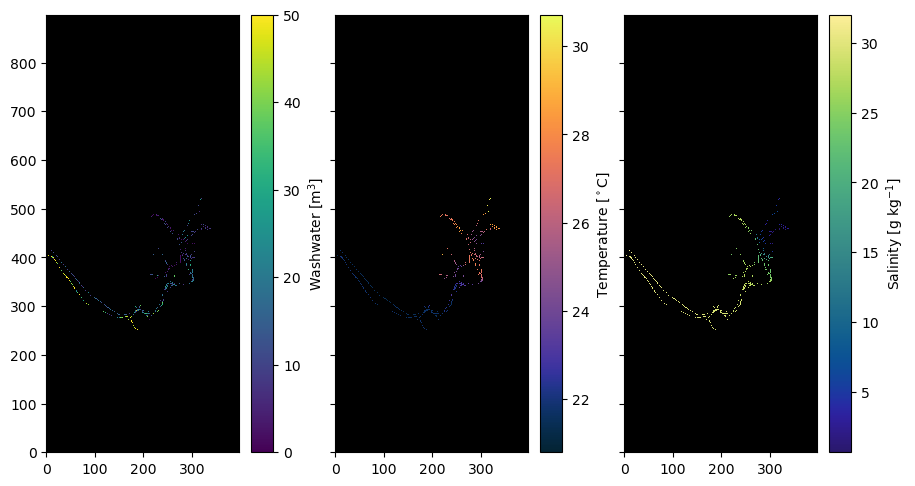

In [41]:
cmap0 = mpl.colormaps['viridis']
cmap0.set_bad('black')

cmap1 = cm.thermal
cmap1.set_bad('black')

cmap2 = cm.haline
cmap2.set_bad('black')

fig, ax = plt.subplots(1, 3, figsize=(9, 5), sharex=True, sharey=True)
fig.tight_layout(pad=1.2)
washwater = ax[0].pcolormesh(np.ma.masked_array(test_year.isel(time=150).washwater, mask=(1-tmask[0])), vmax=50, cmap=cmap0)
temp_out = ax[1].pcolormesh(np.ma.masked_array(test_year.isel(time=150).temp_out, mask=(1-tmask[0])), cmap=cmap1)
sal_out = ax[2].pcolormesh(np.ma.masked_array(test_year.isel(time=150).sal_out, mask=(1-tmask[0])), cmap=cmap2)

cb0 = fig.colorbar(washwater, ax=ax[0])
cb0.set_label(r'Washwater [m$^3$]')
cb1 = fig.colorbar(temp_out, ax=ax[1])
cb1.set_label(r'Temperature [$^\circ$C]')
cb2 = fig.colorbar(sal_out, ax=ax[2])
cb2.set_label(r'Salinity [g kg$^{-1}$]')